# Non-targeted FGSM attacks on the Chars74k dataset

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import pickle
import string

## The Dataset
The x\_\*.pickle and y\_\*.pickle files were pre-made to prevent going through every directory and image of the dataset every single time.

This model is trained on a modified version of the Chars74k English digital fonts dataset. The dataset we are using here only includes ***capital letters*** (i.e. A-Z). Each image is 128x128 pixels

In [0]:
def load_from_files():
  x_train_pkl = open("x_train.pickle", "rb")
  y_train_pkl = open("y_train.pickle", "rb")

  x_test_pkl = open("x_test.pickle", "rb")
  y_test_pkl = open("y_test.pickle", "rb")

  x_train, y_train = pickle.load(x_train_pkl), pickle.load(y_train_pkl)
  x_test, y_test = pickle.load(x_test_pkl), pickle.load(y_test_pkl)

  return (x_train, y_train),(x_test, y_test)

In [0]:
(x_train, y_train),(x_test, y_test) = load_from_files()

In [0]:
x_train = x_train / 255
x_test = x_test / 255

y_train = tf.keras.utils.to_categorical(y_train, 26)
y_test = tf.keras.utils.to_categorical(y_test, 26)

## The Model
This model is a modified version of the model used in the MNIST attacks. The kernel size and strides have been tweaked to account for the larger image sizes.

In [0]:
model = Sequential([
            Conv2D(32,
                kernel_size=(5, 5),
                strides=(1, 1),
                padding='same',
                activation='relu',
                input_shape=(128, 128, 1)),
            Conv2D(64,
                kernel_size=(5, 5),
                strides=(1, 1),
                padding='same',
                activation='relu'),
            Conv2D(64,
                kernel_size=(5, 5),
                strides=(1, 1),
                padding='same',
                activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.2),
            Flatten(),
            Dense(32),
            Dropout(0.2),
            Dense(32),
            Dropout(0.2),
            Dense(26, activation='softmax')
        ])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [0]:
labels = list(string.ascii_uppercase)

In [0]:
model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test))

In [0]:
model.evaluate(x_test, y_test, verbose=2)

165/165 - 7s - loss: 0.0023 - accuracy: 0.9667


[0.0023217082489281893, 0.9666540622711182]

The model is saved in a file to avoid needing to go through the process of training over and over again.

In [0]:
model.save('model.h5')

## The Attacks
These are the same implementations of the MNIST attacks

In [0]:
def mi_fgsm(image, label, decay_factor=1.0, eps=0.1, T=10):
  image = tf.cast(image, tf.float32)
  g_curr = 0
  g_next = 0
  alpha = eps / T
  adv_x = image
  for t in range(T):
    gradient = compute_gradient(adv_x, label)
    L1 = tf.norm(gradient, ord=1)
    g_next = decay_factor*g_curr + (gradient / L1)
    g_curr = g_next
    adv_x = adv_x + alpha * tf.sign(g_next)
  return adv_x.numpy()

In [0]:
def compute_gradient(x, label):
  with tf.GradientTape() as tape:
    tape.watch(x)
    prediction = model(x)
    loss = tf.keras.losses.MSE(label, prediction)
  return tape.gradient(loss, x)

In [0]:
def adversarial_pattern(image, label):
  # Cast to tensor
  image = tf.cast(image, tf.float32)
  gradient = compute_gradient(image, label)
  signed_grad = tf.sign(gradient)
  return signed_grad

In [0]:
def fgsm(image, label, eps=0.1):
  perturbations = adversarial_pattern(image, label).numpy()
  return image + eps*perturbations

## The Results

In [0]:
idx = 1
img = x_test[idx].reshape((-1, 128, 128, 1))
lbl = y_test[idx]

In [0]:
mi_fgsm_adv = mi_fgsm(img, lbl, decay_factor=1.0, eps=0.07, T=10)
fgsm_adv = fgsm(img, lbl, eps=0.1)

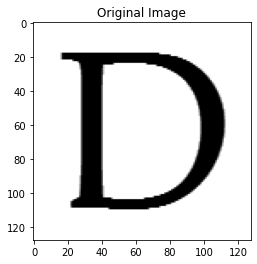

In [192]:
plt.figure()
plt.imshow(img.reshape(128,128), cmap="gray")
plt.title('Original Image')
plt.show()

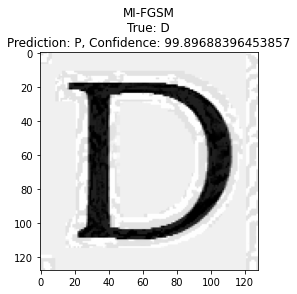

In [190]:
mi_pred = model.predict(mi_fgsm_adv)
mi_conf = mi_pred.max() * 100

plt.figure()
plt.imshow(mi_fgsm_adv.reshape(128,128), cmap="gray")
plt.title('MI-FGSM\nTrue: {}\nPrediction: {}, Confidence: {}'.format(labels[lbl.argmax()],
                                                                     labels[mi_pred.argmax()],
                                                                     mi_conf))
plt.show()

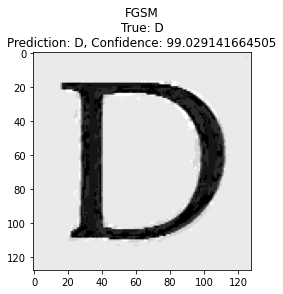

In [186]:
fgsm_pred = model.predict(fgsm_adv)
fgsm_conf = fgsm_pred.max() * 100

plt.figure()
plt.imshow(fgsm_adv.reshape(128,128), cmap="gray")
plt.title('FGSM\nTrue: {}\nPrediction: {}, Confidence: {}'.format(labels[lbl.argmax()],
                                                                     labels[fgsm_pred.argmax()],
                                                                     fgsm_conf))
plt.show()

## Notes
There are some examples in the dataset that will simply not distort no matter how large the epsilon value. This poses an issue, but I do not think it is absolutely terrible because an ML bot will only need to get one letter wrong for the CAPTCHA to fail and I would imagine the probability of getting all X characters of the CAPTCHA to not distort is low. 

More tests need to be done to determine the success rate of our attacks, which we can use to get an idea of how big of an issue the failed attacks are.

I would also need to do testing on different epsilon values to determine what is the best way to approach the setting an epsilon value

Just as a not to the reader, the notebook format is for demonstration purposes and proper python scripts will be available as well